In [ ]:
#clasic sample of anomaly detection
#NYC hourly taxi demand

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import tqdm
import random
import datetime
from sklearn.metrics import mean_squared_log_error

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow.keras.backend as K

In [2]:
### READ DATA AND CREATE FEATURES FOR year, month, day, hour ###

df = pd.read_csv('D:/datamaintanance/nyc_taxi.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['yr'] = df.timestamp.dt.year
df['mt'] = df.timestamp.dt.month
df['d'] = df.timestamp.dt.day
df['H'] = df.timestamp.dt.hour

print(df.shape)
df.head()

(10320, 6)


,timestamp,value,yr,mt,d,H
0,2014-07-01 00:00:00,10844,2014,7,1,0
1,2014-07-01 00:30:00,8127,2014,7,1,0
2,2014-07-01 01:00:00,6210,2014,7,1,1
3,2014-07-01 01:30:00,4656,2014,7,1,1
4,2014-07-01 02:00:00,3820,2014,7,1,2


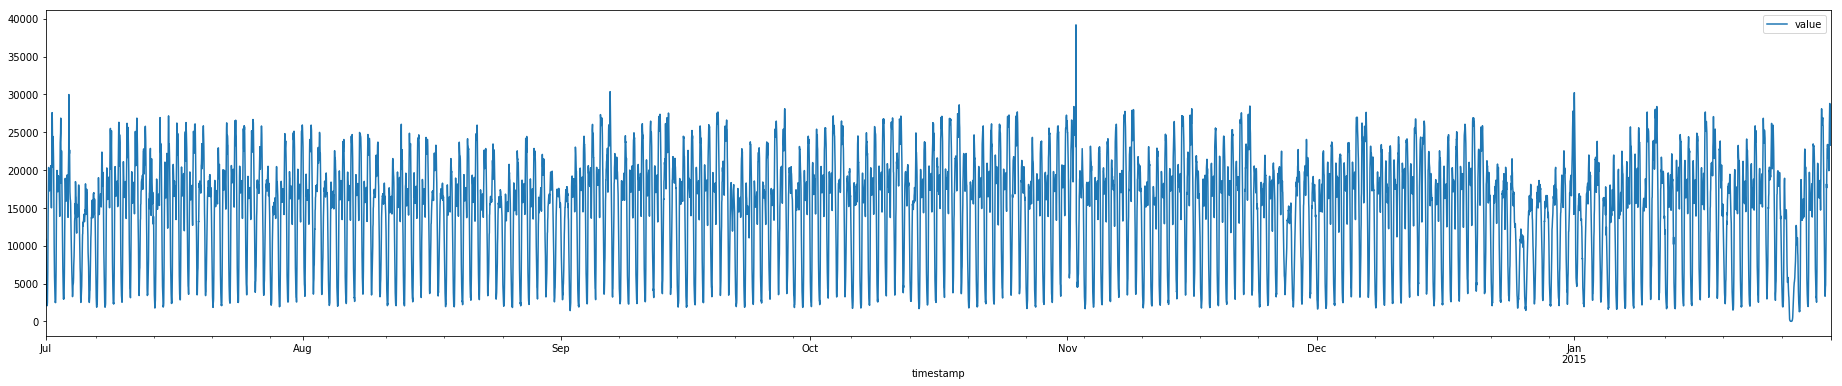

In [3]:
#see the whole data
df.plot(y='value', x='timestamp', figsize=(32,6))

In [4]:
df.iloc[8400:8402]

,timestamp,value,yr,mt,d,H
8400,2014-12-23 00:00:00,10077,2014,12,23,0
8401,2014-12-23 00:30:00,8426,2014,12,23,0


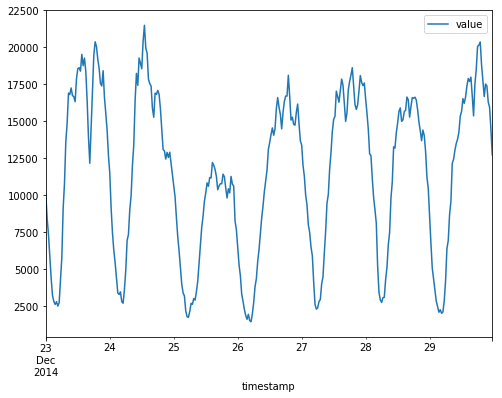

In [5]:
df.iloc[8400:8400+7*48,:].plot(y='value', x='timestamp', figsize=(8,6))

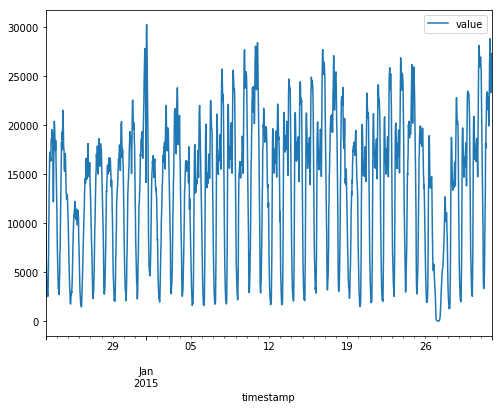

In [6]:
#plot 10 weeks
df.iloc[8400:8400+7*48*10,:].plot(y='value', x='timestamp', figsize=(8,6))

In [7]:
print("relation of an instant with 30 minutes before", df.value.autocorr(lag=1 ) )
print("relation of an instant with 1 day before", df.value.autocorr(lag=48 ) )
print("relation of an instant with 1 week before", df.value.autocorr(lag=48 * 7) )
print("relation of an instant with 2 week before", df.value.autocorr(lag=48 * 7 * 2) )
print("relation of an instant with 10 week before", df.value.autocorr(lag=48 * 7 * 10) )

relation of an instant with 30 minutes before 0.9706377261458449
relation of an instant with 1 day before 0.803990991251698
relation of an instant with 1 week before 0.9213697049247097
relation of an instant with 2 week before 0.8957759735161565
relation of an instant with 10 week before 0.88727614160182


In [8]:
aa = 1.0/4*6
aa

1.5

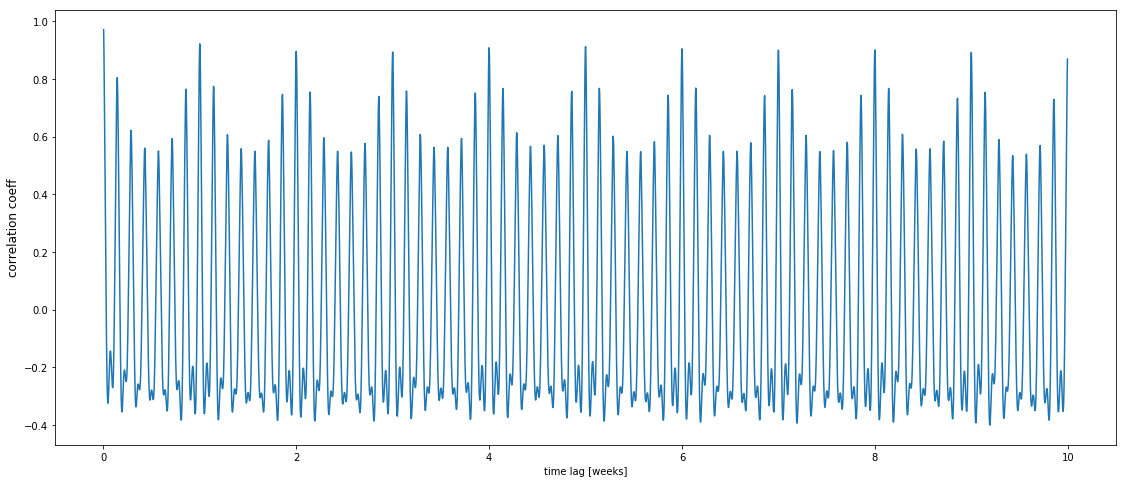

In [9]:
# 10 : 10 weeks
# 48 : 24 hours , measure in every 30 minutes so 48 interval
# 7  : days of week
timeLags = np.arange(1,10*48*7)
autoCorr = [df.value.autocorr(lag=dt) for dt in timeLags]

plt.figure(figsize=(19,8))
plt.plot(1.0/(48*7)*timeLags, autoCorr);
plt.xlabel('time lag [weeks]'); 
plt.ylabel('correlation coeff', fontsize=12);

In [10]:
df.head(5)

,timestamp,value,yr,mt,d,H
0,2014-07-01 00:00:00,10844,2014,7,1,0
1,2014-07-01 00:30:00,8127,2014,7,1,0
2,2014-07-01 01:00:00,6210,2014,7,1,1
3,2014-07-01 01:30:00,4656,2014,7,1,1
4,2014-07-01 02:00:00,3820,2014,7,1,2


In [11]:
#encode weekday , weekday_hour 
df['weekday'] = df.timestamp.dt.weekday
df['weekday_hour'] = df.weekday.astype(str) +' '+ df.H.astype(str)
df['m_weekday'] = df.weekday_hour.replace(df[:5000].groupby('weekday_hour')['value'].mean().to_dict())

In [12]:
df.head(15)

,timestamp,value,yr,mt,d,H,weekday,weekday_hour,m_weekday
0,2014-07-01 00:00:00,10844,2014,7,1,0,1,1 0,8774.433333
1,2014-07-01 00:30:00,8127,2014,7,1,0,1,1 0,8774.433333
2,2014-07-01 01:00:00,6210,2014,7,1,1,1,1 1,5242.933333
3,2014-07-01 01:30:00,4656,2014,7,1,1,1,1 1,5242.933333
4,2014-07-01 02:00:00,3820,2014,7,1,2,1,1 2,3170.433333
5,2014-07-01 02:30:00,2873,2014,7,1,2,1,1 2,3170.433333
6,2014-07-01 03:00:00,2369,2014,7,1,3,1,1 3,2084.466667
7,2014-07-01 03:30:00,2064,2014,7,1,3,1,1 3,2084.466667
8,2014-07-01 04:00:00,2221,2014,7,1,4,1,1 4,2090.066667
9,2014-07-01 04:30:00,2158,2014,7,1,4,1,1 4,2090.066667


In [13]:
def gen_data(df_data,seq_len,columns):
    sub_df = df_data[columns]
    row_count = sub_df.shape[0]
    total_item_to_gen = row_count - seq_len
    for i in range(total_item_to_gen):
        #print(i, i+seq_len)
        yield sub_df[i:i+seq_len ].values.reshape((-1,len(columns)))


In [15]:
sequence_length = 48

In [16]:
cnt, mean = [], []
for sequence in gen_data(df, sequence_length, ['value']):
    cnt.append(sequence)
    
for sequence in gen_data(df, sequence_length, ['m_weekday']):
    mean.append(sequence)

cnt, mean = np.log(cnt), np.log(mean)
cnt = cnt - mean
cnt.shape

(10272, 48, 1)

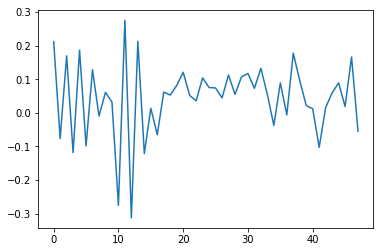

In [17]:
plt.plot( cnt[0] )

In [18]:
def q_loss(q,y,f):
    e = (y-f)
    q_loss_res = K.mean(K.maximum(q*e, (q-1)*e), axis=-1)
    print("q_loss_res",q_loss_res )
    return q_loss_res

In [19]:
init = df.m_weekday[sequence_length:].apply(np.log).values
label = df.value[sequence_length:].apply(np.log).values - init
label.shape

(10272,)

In [20]:
X_train, X_test = cnt[:5000], cnt[5000:]
y_train, y_test = label[:5000], label[5000:]
train_date, test_date = df.timestamp.values[sequence_length:5000+sequence_length], df.timestamp.values[5000+sequence_length:]

In [21]:
tf.random.set_seed(33)
os.environ['PYTHONHASHSEED'] = str(33)
np.random.seed(33)
random.seed(33)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)


### CREATE MODEL ###

losses = [lambda y,f: q_loss(0.1,y,f), lambda y,f: q_loss(0.5,y,f), lambda y,f: q_loss(0.9,y,f)]

inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm = Bidirectional(LSTM(64, return_sequences=True, dropout=0.5))(inputs, training = True)
lstm = Bidirectional(LSTM(16, return_sequences=False, dropout=0.5))(lstm, training = True)
dense = Dense(50)(lstm)
out10 = Dense(1)(dense)
out50 = Dense(1)(dense)
out90 = Dense(1)(dense)
model = Model(inputs, [out10,out50,out90])

model.compile(loss=losses, optimizer='adam', loss_weights = [0.3,0.3,0.3])


In [22]:
model.fit(X_train, [y_train,y_train,y_train], epochs=50, batch_size=128, verbose=2)

Epoch 1/50
q_loss_res Tensor("lambda/Mean:0", shape=(None,), dtype=float32)
q_loss_res Tensor("lambda_1/Mean:0", shape=(None,), dtype=float32)
q_loss_res Tensor("lambda_2/Mean:0", shape=(None,), dtype=float32)
q_loss_res Tensor("lambda/Mean:0", shape=(None,), dtype=float32)
q_loss_res Tensor("lambda_1/Mean:0", shape=(None,), dtype=float32)
q_loss_res Tensor("lambda_2/Mean:0", shape=(None,), dtype=float32)
40/40 - 4s - loss: 0.0287 - dense_1_loss: 0.0277 - dense_2_loss: 0.0442 - dense_3_loss: 0.0238
Epoch 2/50
40/40 - 4s - loss: 0.0264 - dense_1_loss: 0.0242 - dense_2_loss: 0.0421 - dense_3_loss: 0.0216
Epoch 3/50
40/40 - 4s - loss: 0.0258 - dense_1_loss: 0.0230 - dense_2_loss: 0.0413 - dense_3_loss: 0.0216
Epoch 4/50
40/40 - 4s - loss: 0.0254 - dense_1_loss: 0.0225 - dense_2_loss: 0.0409 - dense_3_loss: 0.0212
Epoch 5/50
40/40 - 4s - loss: 0.0250 - dense_1_loss: 0.0219 - dense_2_loss: 0.0402 - dense_3_loss: 0.0211
Epoch 6/50
40/40 - 4s - loss: 0.0247 - dense_1_loss: 0.0216 - dense_2_lo

In [23]:

pred_10, pred_50, pred_90 = [],[],[]
### QUANTILEs BOOTSTRAPPING ###

for i in tqdm.tqdm(range(0,100)):
    
    predd = model.predict(X_test)
    pred_10.append(predd[0])
    pred_50.append(predd[1])
    pred_90.append(predd[2])

pred_10 = np.asarray(pred_10)[:,:,0] 
pred_50 = np.asarray(pred_50)[:,:,0]
pred_90 = np.asarray(pred_90)[:,:,0]



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [05:19<00:00,  3.19s/it]


In [24]:
len(init[5000:])
a = np.array([1,2,3,4,5,8,10,1100])
np.quantile(a, 0.5)
np.exp(a)

C:\Users\mcelikkaya\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


array([2.71828183e+00, 7.38905610e+00, 2.00855369e+01, 5.45981500e+01,
       1.48413159e+02, 2.98095799e+03, 2.20264658e+04,            inf])

In [25]:
### REVERSE TRANSFORM PREDICTIONS ###

pred_90_m = np.exp(np.quantile(pred_90,0.9,axis=0) + init[5000:])
pred_50_m = np.exp(pred_50.mean(axis=0) + init[5000:])
pred_10_m = np.exp(np.quantile(pred_10,0.1,axis=0) + init[5000:])

In [26]:
from sklearn.metrics import mean_squared_log_error
y_true = [2, 5, 2, 2]
y_pred = [4, 5, 4, 4]
mean_squared_log_error(y_true, y_pred)

0.19570711342193498

In [27]:
### EVALUATION METRIC ###

mean_squared_log_error(np.exp(y_test + init[5000:]), pred_50_m)

0.07661990597428603

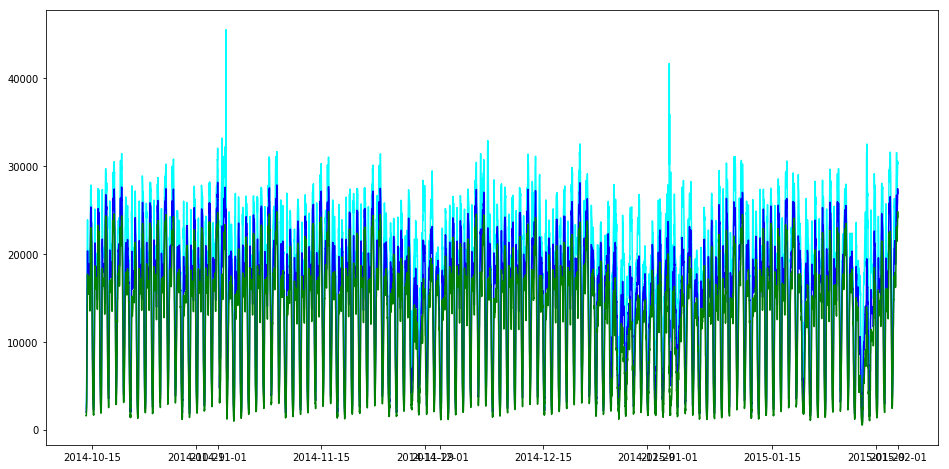

In [28]:
### PLOT QUANTILE PREDICTIONS ###

plt.figure(figsize=(16,8))
plt.plot(test_date, pred_90_m, color='cyan')
plt.plot(test_date, pred_50_m, color='blue')
plt.plot(test_date, pred_10_m, color='green')


### CROSSOVER CHECK ###

plt.scatter(np.where(np.logical_or(pred_50_m>pred_90_m, pred_50_m<pred_10_m))[0], 
            pred_50_m[np.logical_or(pred_50_m>pred_90_m, pred_50_m<pred_10_m)], c='red', s=50)

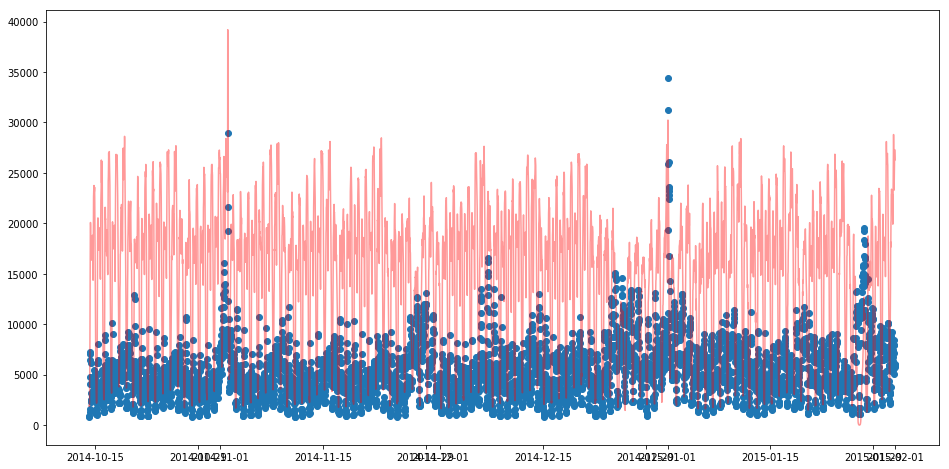

In [29]:
### PLOT UNCERTAINTY INTERVAL LENGHT WITH REAL DATA ###

plt.figure(figsize=(16,8))
plt.plot(test_date, np.exp(y_test + init[5000:]), color='red', alpha=0.4)
plt.scatter(test_date, pred_90_m - pred_10_m)

In [30]:
np.array( pred_90_m - pred_10_m)[0]

846.8529546518635

In [31]:
pred_50_m[np.logical_or(pred_50_m>pred_90_m, pred_50_m<pred_10_m)]

array([], dtype=float64)